In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 33.6 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import math
import random
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.applications import EfficientNetB0, vgg16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Transfer Learning for Image Classification1
# It is highly recommended that you complete this project using Keras2 and Python.

## (a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders

> Data has been downloaded from the Folder.

## (b) Data Exploration and Pre-processing

### i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.
### ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.
### iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [5]:
classes = pd.read_excel("/content/drive/MyDrive/data/Classes.xlsx", names=['folder', 'class'])
classes['folder'] = classes['folder'].str.split('.').str[1]

In [6]:
memcache = classes.set_index('folder').T.to_dict('list')
memcache = dict((k.lower(), v) for k, v in memcache.items())

In [7]:
dirpath = '/content/drive/MyDrive/data/images'
for foldername in os.listdir(dirpath):
    if foldername == ".DS_Store": continue
    temp = []
    for filename in os.listdir(os.path.join(dirpath, foldername)):
        temp.append(os.path.join(dirpath,foldername,filename))
    memcache[foldername.split('.')[1].lower()].append(temp)
    
split_cache = {}
train_images, train_labels, validation_images, validation_labels, test_images, test_labels = [], [], [], [], [], []
for key, values in memcache.items():
    length = len(values[1])
    indices = set([i for i in range(length)])
    train_indices = random.sample(list(indices), math.ceil(0.7*len(indices)))
    indices = indices - set(train_indices)
    validation_indices = random.sample(list(indices), math.ceil(0.15*len(indices)))
    indices = indices - set(validation_indices)
    split_cache[key] = (train_indices, validation_indices, indices)
    
    images = np.array(values[1])
    train_images.extend(images[train_indices])
    train_labels.extend([[values[0]] for _ in train_indices])
    validation_images.extend(images[validation_indices])
    validation_labels.extend([[values[0]] for _ in validation_indices])
    test_images.extend(images[list(indices)])
    test_labels.extend([[values[0]] for _ in indices])

train_df = pd.DataFrame({'Images': train_images, 'Class': train_labels})
validation_df = pd.DataFrame({'Images': validation_images, 'Class': validation_labels})
test_df = pd.DataFrame({'Images': test_images, 'Class': test_labels})

## (c) Transfer Learning

### i. When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained mod- els EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

### ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

### iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [8]:
train_df

,Images,Class
0,/content/drive/MyDrive/data/images/005.Crested...,[0]
1,/content/drive/MyDrive/data/images/005.Crested...,[0]
2,/content/drive/MyDrive/data/images/005.Crested...,[0]
3,/content/drive/MyDrive/data/images/005.Crested...,[0]
4,/content/drive/MyDrive/data/images/005.Crested...,[0]
...,...,...
822,/content/drive/MyDrive/data/images/168.Kentuck...,[19]
823,/content/drive/MyDrive/data/images/168.Kentuck...,[19]
824,/content/drive/MyDrive/data/images/168.Kentuck...,[19]
825,/content/drive/MyDrive/data/images/168.Kentuck...,[19]


In [9]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = train_df, 
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 5,
target_size=(224,224))


test_datagen = ImageDataGenerator()

validation_generator = test_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = validation_df,
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 5,
target_size=(224,224))

Found 827 non-validated image filenames belonging to 20 classes.
Found 59 non-validated image filenames belonging to 20 classes.


In [10]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

def scheduler(epoch, lr):
    lr = 1e-4
    return lr * pow(0.99,epoch)


lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
eff_conv = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in eff_conv.layers[:-1]:
    layer.trainable = False
for layer in eff_conv.layers:
    print(layer, layer.trainable)
filepath = 'efficient_b0_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
model = Sequential()
model.add(eff_conv)
model.add(Flatten())
model.add(Dense(362, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))
opt = Adam()
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=20)])
 
model.summary()

16705208/16705208 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fc986027280> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fc986027b80> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7fc986027df0> False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7fc9857ad4f0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fc9857adf70> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc9fa762fa0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc985765c70> False
<keras.layers.core.activation.Activation object at 0x7fc986027ee0> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fc9857ada90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc9703ff9d0> False
<keras.layers.core.activation.Activation object at 0x7fc97043ca00> False
<keras.layers.pool

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      workers = 10,
      use_multiprocessing = True,
      callbacks = [checkpoint, es, lr])

Epoch 1/100
166/165 [==============================] - ETA: 0s - loss: 2.4564 - accuracy: 0.3313 - precision: 0.5740 - recall: 0.1548 - f1_score: 0.3292
Epoch 1: val_loss improved from inf to 1.22059, saving model to efficient_b0_best_model.hdf5
165/165 [==============================] - 88s 434ms/step - loss: 2.4564 - accuracy: 0.3313 - precision: 0.5740 - recall: 0.1548 - f1_score: 0.3292 - val_loss: 1.2206 - val_accuracy: 0.6610 - val_precision: 0.7708 - val_recall: 0.6271 - val_f1_score: 0.6088 - lr: 1.0000e-04
Epoch 2/100
165/165 [============================>.] - ETA: 0s - loss: 1.5703 - accuracy: 0.5231 - precision: 0.7802 - recall: 0.3540 - f1_score: 0.5197
Epoch 2: val_loss improved from 1.22059 to 0.60441, saving model to efficient_b0_best_model.hdf5
165/165 [==============================] - 22s 119ms/step - loss: 1.5729 - accuracy: 0.5236 - precision: 0.7819 - recall: 0.3555 - f1_score: 0.5200 - val_loss: 0.6044 - val_accuracy: 0.8305 - val_precision: 0.9333 - val_recall: 0

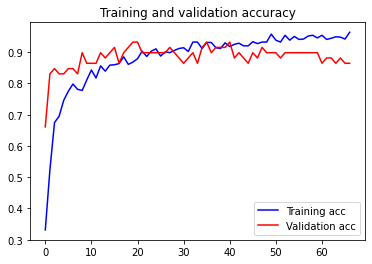

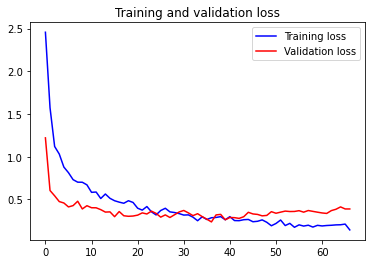

In [13]:
visualize_results(history)

In [14]:
test_generator = test_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = test_df,
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 5,
target_size=(224,224))

model = load_model(filepath)
print(f"Loading model {filepath}")
loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator, verbose = 1)
print("Test Loss", loss)
print("Test Accuracy", accuracy)
print("Test Precision", precision)
print("Test Recall", recall)
print("Test F1 Score", f1_score.mean())

Found 290 non-validated image filenames belonging to 20 classes.
Loading model efficient_b0_best_model.hdf5
58/58 [==============================] - 216s 4s/step - loss: 0.2162 - accuracy: 0.9379 - precision: 0.9638 - recall: 0.9172 - f1_score: 0.9382
Test Loss 0.21617476642131805
Test Accuracy 0.9379310607910156
Test Precision 0.9637681245803833
Test Recall 0.9172413945198059
Test F1 Score 0.9381998


In [16]:
vgg_conv = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape=(224, 224, 3))
for layer in vgg_conv.layers[:-1]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)
filepath = 'vgg_16_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
model = Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(362, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))
opt = Adam()
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=20)])
 
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fc8e69025e0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e69027c0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e6902700> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc9ef26d040> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e690fb20> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e690f0a0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc8e6902e80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e6917ac0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e691b370> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e691b0d0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc8e691b7c0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8e6925160> False
<keras.layers.convolutional.con

In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      workers = 10,
      use_multiprocessing = True,
      callbacks = [checkpoint, es, lr])

Epoch 1/100
166/165 [==============================] - ETA: 0s - loss: 3.0205 - accuracy: 0.1536 - precision_1: 0.3253 - recall_1: 0.0326 - f1_score: 0.1514
Epoch 1: val_loss improved from inf to 1.66463, saving model to vgg_16_best_model.hdf5
165/165 [==============================] - 26s 135ms/step - loss: 3.0205 - accuracy: 0.1536 - precision_1: 0.3253 - recall_1: 0.0326 - f1_score: 0.1514 - val_loss: 1.6646 - val_accuracy: 0.5593 - val_precision_1: 0.7692 - val_recall_1: 0.3390 - val_f1_score: 0.4900 - lr: 1.0000e-04
Epoch 2/100
166/165 [==============================] - ETA: 0s - loss: 2.0817 - accuracy: 0.3615 - precision_1: 0.6353 - recall_1: 0.1306 - f1_score: 0.3566
Epoch 2: val_loss improved from 1.66463 to 1.20591, saving model to vgg_16_best_model.hdf5
165/165 [==============================] - 20s 116ms/step - loss: 2.0817 - accuracy: 0.3615 - precision_1: 0.6353 - recall_1: 0.1306 - f1_score: 0.3566 - val_loss: 1.2059 - val_accuracy: 0.6102 - val_precision_1: 0.7500 - val

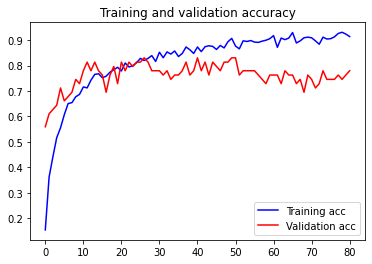

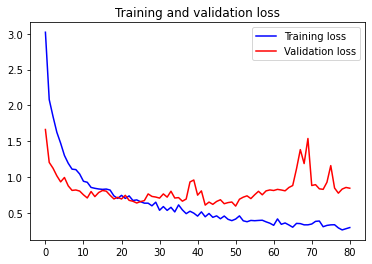

In [18]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [19]:
test_generator = test_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = test_df,
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 5,
target_size=(224,224))

model = load_model(filepath)
print(f"Loading model {filepath}")
loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator, verbose = 1)
print("Test Loss", loss)
print("Test Accuracy", accuracy)
print("Test Precision", precision)
print("Test Recall", recall)
print("Test F1 Score", f1_score.mean())

Found 290 non-validated image filenames belonging to 20 classes.
Loading model vgg_16_best_model.hdf5
58/58 [==============================] - 3s 42ms/step - loss: 0.8152 - accuracy: 0.7655 - precision_1: 0.8137 - recall_1: 0.7379 - f1_score: 0.7633
Test Loss 0.8151741027832031
Test Accuracy 0.7655172348022461
Test Precision 0.8136882185935974
Test Recall 0.7379310131072998
Test F1 Score 0.7632772


### v. Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.

> Precision Recall F1 Score for both models have been reported above after each of the individual model runs.